# CNN Experiments in time series

In [42]:
import numpy
import pandas
import matplotlib.pyplot as plt

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [43]:
class GARCHTimeSeriesDataGenerator:
    """
    A class for generating time series data using the GARCH process.

    Parameters:
    - start_date (str): The start date of the time series.
    - years (int): The number of years to simulate. Default is 1.
    - mu (float): The mean of the GARCH process. Default is 0.
    - omega (float): The constant term in the GARCH process. Default is 0.1.
    - alpha (list): The list of alpha coefficients in the GARCH process. Default is [0.5].
    - beta (list): The list of beta coefficients in the GARCH process. Default is [0.5].
    """

    def __init__(self, start_date, years=1, mu=0, omega=0.1, alpha=[0.5], beta=[0.5]):
        self.start_date = pandas.to_datetime(start_date)
        self.years = years
        self.mu = mu
        self.omega = omega
        self.alpha = alpha
        self.beta = beta

    def simulate(self, n) -> pandas.Series:
        """
        Simulates a GARCH process and returns a pandas Series of simulated returns.

            Parameters:
            - n (int): The number of periods to simulate.

            Returns:
            - simulated_series (pandas.Series): A pandas Series of simulated returns.
        """
        # Calculate the total number of periods
        total_periods = n * self.years

        # Initialize arrays
        errors = numpy.random.normal(size=total_periods)
        sigmas = numpy.zeros_like(errors)
        returns = numpy.zeros_like(errors)

        # Simulate GARCH process
        for t in range(1, total_periods):
            sigmas[t] = numpy.sqrt(
                self.omega + self.alpha[0] * errors[t-1]**2 + self.beta[0] * sigmas[t-1]**2)
            returns[t] = self.mu + sigmas[t] * errors[t]

        # Create date range
        dates = pandas.date_range(self.start_date, periods=total_periods)

        # Create pandas Series
        simulated_series = pandas.Series(returns, index=dates)

        return simulated_series


### First Experiment

This first experiment uses a CNN for unsupervised anomaly detection, by mapping a value to a canvas of pixels.



In [44]:
# Create a GARCH time series data generator
generator = GARCHTimeSeriesDataGenerator(start_date="2023-01-01")

# Simulate days of data (assuming daily data)
data = generator.simulate(1825)

# Normalize data to a range of 0 to 16777215
normalized_data = (data - data.min()) / (data.max() - data.min()) * 16777215

In [45]:
import json
# Create a canvas with 365 pixels
canvas = numpy.zeros((normalized_data.size, 3), dtype=numpy.uint8)
dates = []

# Iterate through each pixel and set the color based on normalized data
for i in range(normalized_data.size):
  # Extract the normalized value for the current day
  value = normalized_data.iloc[i]
  date = normalized_data.index[i]
  # Convert the value to RGB components
  red = (int(value) & 0x00FF0000) >> 16
  green = (int(value) & 0x0000FF00) >> 8
  blue = int(value) & 0x000000FF

  # Set the pixel's RGB values
  canvas[i] = [red, green, blue]
  dates.append(date)

canvas_dictionary = {dates[i]: canvas[i] for i in range(len(dates))}

def save_source_data():
    # Specify the file path to save the JSON file
    file_path = 'sourceData\canvas_dictionary.json'
    # Convert the canvas array to a list
    canvas_list = canvas.tolist()
    canvas_dictionary = {
        str(date): canvas_list[i] for i, date in enumerate(dates)}
    # Open the file in write mode
    with open(file_path, 'w') as file:
        # Write the dictionary to the JSON file
        json.dump(canvas_dictionary, file)

# Call the function to save the canvas_dictionary to a JSON file
save_source_data()
    

In [46]:
plt.imshow(canvas_dictionary.values())
plt.axis('off')

(-0.5, 2.5, 1824.5, -0.5)

In [47]:
import datetime

# Create dictionaries for each month
canvas_dictionaries_by_month = {}
start_year = list(canvas_dictionary.keys())[0].year
end_year = list(canvas_dictionary.keys())[-1].year
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        # Filter canvas_dictionary by month and year
        filtered_dictionary = {key: value for key, value in canvas_dictionary.items() if key.month == month and key.year == year}
        # Add filtered dictionary to canvas_dictionaries_by_month
        month_name = datetime.date(1900, month, 1).strftime('%B')
        canvas_dictionaries_by_month[f'canvas_dictionary_{month_name.lower()}_{year}'] = filtered_dictionary

# Print the canvas dictionaries for each month and year
for month, dictionary in canvas_dictionaries_by_month.items():
    print("\n-----------------")
    print(f'{month}: {dictionary}')
    print("-----------------\n")



-----------------
canvas_dictionary_january_2023: {Timestamp('2023-01-01 00:00:00'): array([166,  72,  37], dtype=uint8), Timestamp('2023-01-02 00:00:00'): array([165, 117, 255], dtype=uint8), Timestamp('2023-01-03 00:00:00'): array([171,   0, 166], dtype=uint8), Timestamp('2023-01-04 00:00:00'): array([179, 156, 169], dtype=uint8), Timestamp('2023-01-05 00:00:00'): array([156, 187,  70], dtype=uint8), Timestamp('2023-01-06 00:00:00'): array([172, 239, 187], dtype=uint8), Timestamp('2023-01-07 00:00:00'): array([145, 110, 191], dtype=uint8), Timestamp('2023-01-08 00:00:00'): array([145,  18,  62], dtype=uint8), Timestamp('2023-01-09 00:00:00'): array([174, 252,   6], dtype=uint8), Timestamp('2023-01-10 00:00:00'): array([177, 137,  83], dtype=uint8), Timestamp('2023-01-11 00:00:00'): array([184, 101, 201], dtype=uint8), Timestamp('2023-01-12 00:00:00'): array([131,  97, 145], dtype=uint8), Timestamp('2023-01-13 00:00:00'): array([176, 155,  17], dtype=uint8), Timestamp('2023-01-14 00:

<Figure size 640x480 with 0 Axes>

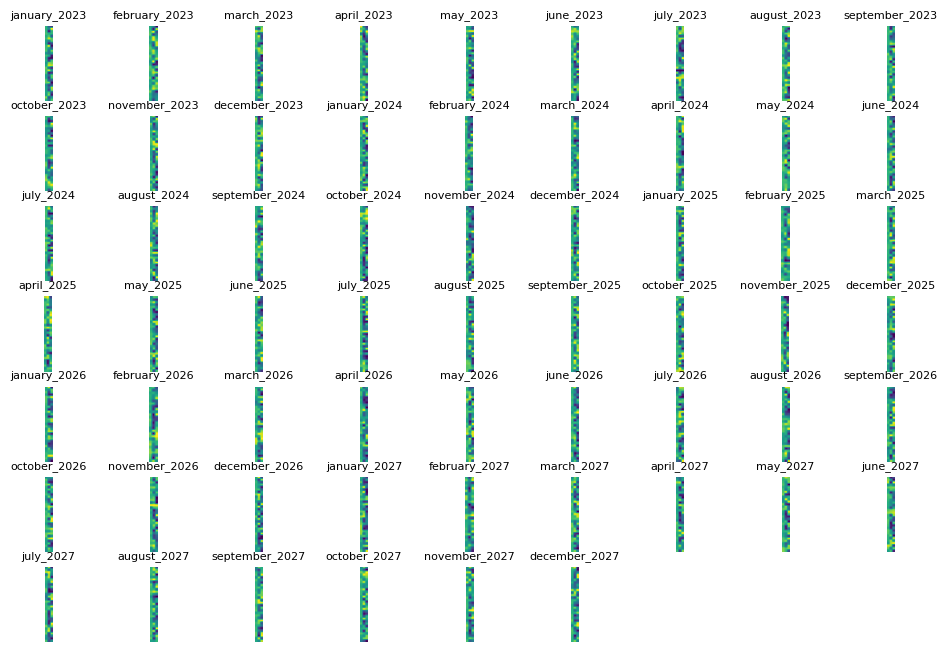

In [48]:
import os

directory = 'cnn_monthly_images/'
# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
elif os.path.exists(directory):
    # Get a list of all files in the directory
    file_list = os.listdir(directory)
    if len(file_list) > 0:
        # Delete each file in the directory
        for file_name in file_list:
            file_path = os.path.join(directory, file_name)
            if file_path.endswith('.png'):
                os.remove(file_path)
for month, dictionary in canvas_dictionaries_by_month.items():
    canvas_dictionary_month = {key: value for key, value in dictionary.items()}
    #print(f"-----{month}-----")
    #plt.imshow(canvas_dictionary_month.values())
    #plt.axis('off')
    plt.savefig(f'{directory}{month}.png')
    #plt.show()


def subplot_data_for_viewing(directory='cnn_monthly_images/'):
    # Calculate the number of rows and columns for subplots
    num_subplots = len(canvas_dictionaries_by_month)
    num_rows = int(num_subplots ** 0.5)
    num_cols = int(num_subplots / num_rows) + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    # Flatten the axes array if it's multidimensional
    if num_rows > 1:
        axes = axes.flatten()
    # Iterate over each month and dictionary

    for i, (month, dictionary) in enumerate(canvas_dictionaries_by_month.items()):

        canvas_dictionary_month = {key: value for key, value in dictionary.items()}

        ax = axes[i] if num_subplots > 1 else axes
        ax.imshow(list(canvas_dictionary_month.values()))
        ax.axis('off')
        title = month[month.find("_")+12:]
        ax.set_title(title, fontsize=8)

    # Remove any unused subplots
    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])

    # Save the figure
    plt.savefig(f'{directory}\canvas_dictionary_subplots.png')
    plt.show()
    

subplot_data_for_viewing()

In [49]:
# Set the directory path of your images
image_directory = 'cnn_monthly_images/'

# Define a custom dataset class

class ImageDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
# Get a list of all image file names in the directory
image_files = [os.path.join(image_directory, file) for file in os.listdir(
    image_directory) if file.endswith('.png')]

train_image_files = image_files[:int(len(image_files) * 0.9)]
test_image_files = image_files[int(len(image_files) * 0.9):]

print(f"Total number of images for training: {len(train_image_files)}")
print(f"Total number of images for testing: {len(test_image_files)}")

data = {}

data['train'] = ImageDataset(train_image_files, transform=transform)
data['valid'] = ImageDataset(test_image_files, transform=transform)

loaders = {}

loaders['train'] = DataLoader(data['train'], batch_size=4, shuffle=True)
loaders['valid'] = DataLoader(data['valid'], batch_size=4, shuffle=True)

Total number of images for training: 54
Total number of images for testing: 7


In [51]:
dataiter = next(iter(loaders['train']))
images = dataiter.numpy()
print(images.shape)

def show_images():
    import matplotlib.pyplot as plt

    # Iterate over the images in loader['train']
    for images in loaders['train']:
        # Iterate over each image in the batch
        for image in images:
            # Plot the image
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.show()



(4, 3, 256, 256)


In [18]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Create the autoencoder model
model = Autoencoder()

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model.cuda()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    train_loss_list = []
    valid_loss_list = []

    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch_idx, data in enumerate(loaders['train']):
            if use_cuda:
                data = data.cuda()

            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(loaders['valid']):
                if use_cuda:
                    data = data.cuda()

                output = model.forward(data)
                loss = criterion(output, data)

                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
        ))

        train_loss_list.append(train_loss.item())
        valid_loss_list.append(valid_loss.item())

        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model, train_loss_list, valid_loss_list


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# train the model
n_epochs = 240
model_name = 'conv_Autoencoder_anomaly_adam_lr0001.pt'
save_path = fr'modelOutput\{model_name}'
model_transfer, train_loss, valid_loss = train(
    n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path)

Epoch: 1 	Training Loss: 3.520055 	Validation Loss: 2.852115
Validation loss decreased (inf --> 2.852115).  Saving model ...
Epoch: 2 	Training Loss: 2.524959 	Validation Loss: 2.349565
Validation loss decreased (2.852115 --> 2.349565).  Saving model ...
Epoch: 3 	Training Loss: 2.293309 	Validation Loss: 2.245907
Validation loss decreased (2.349565 --> 2.245907).  Saving model ...
Epoch: 4 	Training Loss: 2.241670 	Validation Loss: 2.230405
Validation loss decreased (2.245907 --> 2.230405).  Saving model ...
Epoch: 5 	Training Loss: 2.177709 	Validation Loss: 2.159669
Validation loss decreased (2.230405 --> 2.159669).  Saving model ...
Epoch: 6 	Training Loss: 2.136883 	Validation Loss: 2.093341
Validation loss decreased (2.159669 --> 2.093341).  Saving model ...
Epoch: 7 	Training Loss: 2.093299 	Validation Loss: 2.093319
Validation loss decreased (2.093341 --> 2.093319).  Saving model ...
Epoch: 8 	Training Loss: 2.093179 	Validation Loss: 2.092834
Validation loss decreased (2.09331

In [21]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(
    save_path))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1

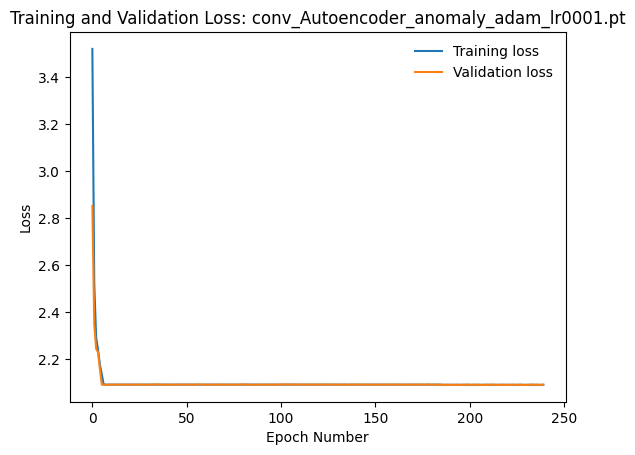

In [22]:
def plot_loss(train_loss, valid_loss, save_path):
    n = np.arange(0, n_epochs)
    plt.plot(n, train_loss, label='Training loss')
    plt.plot(n, valid_loss, label='Validation loss')
    plt.title('Training and Validation Loss: {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch Number')
    plt.legend(frameon=False)
    plt.savefig(save_path)
    plt.show()

plot_loss(train_loss, valid_loss, fr'modelOutput\{model_name}_loss.png')

In [23]:
import json

loss_data = {}
loss_data['train'] = train_loss
loss_data['valid'] = valid_loss

if not os.path.isfile(f'modelOutput/{model_name}_loss_data.json'):
    with open(f'modelOutput/{model_name}_loss_data.json', 'w') as f:
        json.dump(loss_data, f)

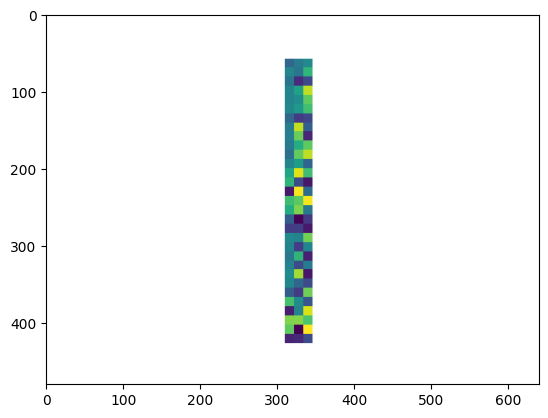

In [24]:
import os
import random
from PIL import Image

image_directory = "cnn_monthly_images/"
image_files = os.listdir(image_directory)
random_image_file = random.choice(image_files)
image_path = os.path.join(image_directory, random_image_file)
image = Image.open(image_path).convert('RGB')

plt.imshow(image)
plt.show()